# Imports

In [1]:
import os
import time
import torch
import random 
import sklearn

import numpy as np
import pandas as pd
from math import log
import seaborn as sns
import xgboost as xgb

from torch.nn import LSTM
from numpy import absolute
from torch import nn, optim
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Mounting Data

In [2]:
# Link to the data: https://drive.google.com/drive/folders/1jWcl_S0X-qJ_6wvkYwYTpoTyC46Vo7q0?usp=share_link 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/Colab Notebooks/ML_Project/python scripts/Dataset

/content/drive/.shortcut-targets-by-id/1ZuzKbs6Snda1BMsw7T86kGv47GtX_XOe/ML_Project/python scripts/Dataset


In [4]:
#from google.colab import files
#uploaded = files.upload()


**Dataset**

Confidence Indicators = **754**; 1960-01

Federal Funds (Daily) = 1827; 2017-Nov

Federal Funds (Monthly) = **61** 

Housing Index = **11** 

GDP = **309**; 1997-01

Median CPI = **478**; 1983-01

Non-Farm Payroll = **1006**; 1939-01

PCE = **765**; 1959-01

Treasury Maturity (Daily) = 1305; 2017-11

Treasury Maturity (Monthly) = **61**

Unemployment Rate = **898**; 1948-01

# Cleaning Economic Indicators Dataset

In [5]:
Conf_Indicators = pd.read_csv(r'CSCICP03USM665S.csv')
print(Conf_Indicators)

           DATE  CSCICP03USM665S
0    1960-01-01       101.643267
1    1960-02-01       101.375837
2    1960-03-01       101.144800
3    1960-04-01       101.017357
4    1960-05-01       101.049532
..          ...              ...
749  2022-06-01        96.029397
750  2022-07-01        95.997265
751  2022-08-01        96.279242
752  2022-09-01        96.556111
753  2022-10-01        96.799160

[754 rows x 2 columns]


In [6]:
#slt_df = Conf_Indicators[Conf_Indicators['DATE'] > "1997-01-01" and Conf_Indicators['DATE'] < "2022-10-01"] as.numeric(window(producers.price, 2015.1, 2015.2))
Conf_Indicators["DATE"] = pd.to_datetime(Conf_Indicators["DATE"])
Conf_Indicators_309 = Conf_Indicators[Conf_Indicators['DATE'] >= pd.to_datetime("1997-01-01")].reset_index() # and Conf_Indicators['DATE'] < pd.to_datetime("2022-10-01")]
print(Conf_Indicators_309)

     index       DATE  CSCICP03USM665S
0      444 1997-01-01       101.448884
1      445 1997-02-01       101.570988
2      446 1997-03-01       101.708459
3      447 1997-04-01       101.879084
4      448 1997-05-01       102.071853
..     ...        ...              ...
305    749 2022-06-01        96.029397
306    750 2022-07-01        95.997265
307    751 2022-08-01        96.279242
308    752 2022-09-01        96.556111
309    753 2022-10-01        96.799160

[310 rows x 3 columns]


In [7]:
Federal_Funds = pd.read_csv(r'DFF.csv')
print(Federal_Funds)
Federal_Funds_resample = Federal_Funds.groupby(pd.PeriodIndex(Federal_Funds['DATE'], freq="M"))['DFF'].mean().reset_index()
print(Federal_Funds_resample)

            DATE   DFF
0     2017-11-25  1.16
1     2017-11-26  1.16
2     2017-11-27  1.16
3     2017-11-28  1.16
4     2017-11-29  1.16
...          ...   ...
1822  2022-11-21  3.83
1823  2022-11-22  3.83
1824  2022-11-23  3.83
1825  2022-11-24  3.83
1826  2022-11-25  3.83

[1827 rows x 2 columns]
       DATE       DFF
0   2017-11  1.145000
1   2017-12  1.301613
2   2018-01  1.414516
3   2018-02  1.417500
4   2018-03  1.506129
..      ...       ...
56  2022-07  1.675806
57  2022-08  2.330000
58  2022-09  2.555000
59  2022-10  3.080000
60  2022-11  3.770000

[61 rows x 2 columns]


In [8]:
Housing_Index = pd.read_csv(r'FIXHAI.csv')
print(Housing_Index)

          DATE  FIXHAI
0   2021-10-01   143.5
1   2021-11-01   142.7
2   2021-12-01   142.2
3   2022-01-01   137.3
4   2022-02-01   129.4
5   2022-03-01   118.8
6   2022-04-01   104.1
7   2022-05-01    98.3
8   2022-06-01    94.5
9   2022-07-01    99.6
10  2022-08-01   103.8
11  2022-09-01    96.6


In [9]:
GDP = pd.read_csv(r'GEPUCURRENT.csv')
print(GDP)

           DATE  GEPUCURRENT
0    1997-01-01    76.906476
1    1997-02-01    79.425191
2    1997-03-01    68.601187
3    1997-04-01    73.800693
4    1997-05-01    71.874695
..          ...          ...
304  2022-05-01   288.911311
305  2022-06-01   268.762066
306  2022-07-01   312.428051
307  2022-08-01   255.767938
308  2022-09-01   268.812365

[309 rows x 2 columns]


In [10]:
Median_CPI = pd.read_csv(r'MEDCPIM158SFRBCLE.csv')
print(Median_CPI)

           DATE  MEDCPIM158SFRBCLE
0    1983-01-01           5.014653
1    1983-02-01           4.952545
2    1983-03-01           3.612261
3    1983-04-01           4.828054
4    1983-05-01           3.767326
..          ...                ...
473  2022-06-01           9.130538
474  2022-07-01           6.483074
475  2022-08-01           9.222973
476  2022-09-01           8.307776
477  2022-10-01           6.532852

[478 rows x 2 columns]


In [11]:
Median_CPI["DATE"] = pd.to_datetime(Median_CPI["DATE"])
Median_CPI_309 = Median_CPI[Median_CPI['DATE'] >= pd.to_datetime("1997-01-01")].reset_index() # and Conf_Indicators['DATE'] < pd.to_datetime("2022-10-01")]
print(Median_CPI_309)

     index       DATE  MEDCPIM158SFRBCLE
0      168 1997-01-01           3.026179
1      169 1997-02-01           2.342950
2      170 1997-03-01           2.953195
3      171 1997-04-01           2.987708
4      172 1997-05-01           2.635673
..     ...        ...                ...
305    473 2022-06-01           9.130538
306    474 2022-07-01           6.483074
307    475 2022-08-01           9.222973
308    476 2022-09-01           8.307776
309    477 2022-10-01           6.532852

[310 rows x 3 columns]


In [12]:
NonFarm_Payroll = pd.read_csv(r'PAYEMS.csv')
print(NonFarm_Payroll)

            DATE  PAYEMS
0     1939-01-01   29923
1     1939-02-01   30100
2     1939-03-01   30280
3     1939-04-01   30094
4     1939-05-01   30299
...          ...     ...
1001  2022-06-01  151903
1002  2022-07-01  152440
1003  2022-08-01  152732
1004  2022-09-01  153047
1005  2022-10-01  153308

[1006 rows x 2 columns]


In [13]:
NonFarm_Payroll["DATE"] = pd.to_datetime(NonFarm_Payroll["DATE"])
NonFarm_Payroll_309 = NonFarm_Payroll[NonFarm_Payroll['DATE'] >= pd.to_datetime("1997-01-01")].reset_index() # and Conf_Indicators['DATE'] < pd.to_datetime("2022-10-01")]
print(NonFarm_Payroll_309)

     index       DATE  PAYEMS
0      696 1997-01-01  121363
1      697 1997-02-01  121675
2      698 1997-03-01  121990
3      699 1997-04-01  122286
4      700 1997-05-01  122546
..     ...        ...     ...
305   1001 2022-06-01  151903
306   1002 2022-07-01  152440
307   1003 2022-08-01  152732
308   1004 2022-09-01  153047
309   1005 2022-10-01  153308

[310 rows x 3 columns]


In [14]:
PCE = pd.read_csv(r'PCE.csv')
print(PCE)

           DATE      PCE
0    1959-01-01    306.1
1    1959-02-01    309.6
2    1959-03-01    312.7
3    1959-04-01    312.2
4    1959-05-01    316.1
..          ...      ...
760  2022-05-01  17231.1
761  2022-06-01  17437.4
762  2022-07-01  17398.1
763  2022-08-01  17495.0
764  2022-09-01  17607.9

[765 rows x 2 columns]


In [15]:
PCE["DATE"] = pd.to_datetime(PCE["DATE"])
PCE_309 = PCE[PCE['DATE'] >= pd.to_datetime("1997-01-01")].reset_index() # and Conf_Indicators['DATE'] < pd.to_datetime("2022-10-01")]
print(PCE_309)

     index       DATE      PCE
0      456 1997-01-01   5411.1
1      457 1997-02-01   5434.0
2      458 1997-03-01   5454.2
3      459 1997-04-01   5459.3
4      460 1997-05-01   5460.2
..     ...        ...      ...
304    760 2022-05-01  17231.1
305    761 2022-06-01  17437.4
306    762 2022-07-01  17398.1
307    763 2022-08-01  17495.0
308    764 2022-09-01  17607.9

[309 rows x 3 columns]


In [16]:
Treasury_Maturity = pd.read_csv(r'T10Y3M.csv')
print(Treasury_Maturity)

            DATE T10Y3M
0     2017-11-28   1.04
1     2017-11-29   1.08
2     2017-11-30   1.15
3     2017-12-01    1.1
4     2017-12-04   1.08
...          ...    ...
1300  2022-11-22  -0.64
1301  2022-11-23  -0.69
1302  2022-11-24      .
1303  2022-11-25  -0.73
1304  2022-11-28  -0.72

[1305 rows x 2 columns]


In [17]:
Treasury_Maturity_copy = Treasury_Maturity
#Treasury_Maturity_copy['T10Y3M'].replace('.', np.NaN)
Treasury_Maturity_copy['T10Y3M']=pd.to_numeric(Treasury_Maturity_copy['T10Y3M'], errors='coerce')
print(Treasury_Maturity_copy)
Treasury_Maturity_resampled = Treasury_Maturity_copy.groupby(pd.PeriodIndex(Treasury_Maturity_copy['DATE'], freq="M"))['T10Y3M'].mean().reset_index()
print(Treasury_Maturity_resampled)

            DATE  T10Y3M
0     2017-11-28    1.04
1     2017-11-29    1.08
2     2017-11-30    1.15
3     2017-12-01    1.10
4     2017-12-04    1.08
...          ...     ...
1300  2022-11-22   -0.64
1301  2022-11-23   -0.69
1302  2022-11-24     NaN
1303  2022-11-25   -0.73
1304  2022-11-28   -0.72

[1305 rows x 2 columns]
       DATE    T10Y3M
0   2017-11  1.090000
1   2017-12  1.061000
2   2018-01  1.151429
3   2018-02  1.271053
4   2018-03  1.115714
..      ...       ...
56  2022-07  0.598000
57  2022-08  0.176087
58  2022-09  0.297143
59  2022-10  0.111000
60  2022-11 -0.406667

[61 rows x 2 columns]


In [18]:
Unemployment_Rate = pd.read_csv(r'UNRATE.csv')
print(Unemployment_Rate)

           DATE  UNRATE
0    1948-01-01     3.4
1    1948-02-01     3.8
2    1948-03-01     4.0
3    1948-04-01     3.9
4    1948-05-01     3.5
..          ...     ...
893  2022-06-01     3.6
894  2022-07-01     3.5
895  2022-08-01     3.7
896  2022-09-01     3.5
897  2022-10-01     3.7

[898 rows x 2 columns]


In [19]:
Unemployment_Rate["DATE"] = pd.to_datetime(Unemployment_Rate["DATE"])
Unemployment_Rate_309 = Unemployment_Rate[Unemployment_Rate['DATE'] >= pd.to_datetime("1997-01-01")].reset_index() # and Conf_Indicators['DATE'] < pd.to_datetime("2022-10-01")]
print(Unemployment_Rate_309)

     index       DATE  UNRATE
0      588 1997-01-01     5.3
1      589 1997-02-01     5.2
2      590 1997-03-01     5.2
3      591 1997-04-01     5.1
4      592 1997-05-01     4.9
..     ...        ...     ...
305    893 2022-06-01     3.6
306    894 2022-07-01     3.5
307    895 2022-08-01     3.7
308    896 2022-09-01     3.5
309    897 2022-10-01     3.7

[310 rows x 3 columns]


In [20]:
df_309 = pd.concat([GDP, Conf_Indicators_309["CSCICP03USM665S"], Median_CPI_309["MEDCPIM158SFRBCLE"], NonFarm_Payroll_309["PAYEMS"], PCE_309["PCE"], Unemployment_Rate_309["UNRATE"]], axis=1)
df_309['index'] = df_309.index
df_309

,DATE,GEPUCURRENT,CSCICP03USM665S,MEDCPIM158SFRBCLE,PAYEMS,PCE,UNRATE,index
0,1997-01-01,76.906476,101.448884,3.026179,121363,5411.1,5.3,0
1,1997-02-01,79.425191,101.570988,2.342950,121675,5434.0,5.2,1
2,1997-03-01,68.601187,101.708459,2.953195,121990,5454.2,5.2,2
3,1997-04-01,73.800693,101.879084,2.987708,122286,5459.3,5.1,3
4,1997-05-01,71.874695,102.071853,2.635673,122546,5460.2,4.9,4
...,...,...,...,...,...,...,...,...
305,2022-06-01,268.762066,96.029397,9.130538,151903,17437.4,3.6,305
306,2022-07-01,312.428051,95.997265,6.483074,152440,17398.1,3.5,306
307,2022-08-01,255.767938,96.279242,9.222973,152732,17495.0,3.7,307
308,2022-09-01,268.812365,96.556111,8.307776,153047,17607.9,3.5,308


In [21]:
df_309=df_309.rename(columns={"CSCICP03USM665S": "Conf_Indicators", "GEPUCURRENT":"GDP", "MEDCPIM158SFRBCLE":"Median_CPI", "PAYEMS":"NonFarm_Payroll"})

# Gold and Silver Dataset

In [22]:
df = pd.read_csv(r'combinedData752.csv')
df

,Unnamed: 0,index,DATE,GDP,Conf_Indicators,CPI,NonFarm_Payroll,PCE,UNRATE
0,0,0,1960-01-01,101.009477,101.643267,-0.340136,54274,323.6,5.2
1,1,1,1960-02-01,101.019803,101.375837,0.341297,54513,325.3,4.8
2,2,2,1960-03-01,100.943976,101.144800,0.000000,54454,330.2,5.4
3,3,3,1960-04-01,100.784465,101.017357,0.340136,54813,336.5,5.2
4,4,4,1960-05-01,100.560223,101.049532,0.000000,54475,330.0,5.1
...,...,...,...,...,...,...,...,...,...
747,747,747,2022-04-01,99.916264,96.864482,0.558253,151224,17115.6,3.6
748,748,748,2022-05-01,99.810129,96.448281,1.102352,151610,17231.1,3.6
749,749,749,2022-06-01,99.741208,96.029397,1.373608,151903,17437.4,3.6
750,750,750,2022-07-01,99.703565,95.997265,-0.011812,152440,17398.1,3.5


In [23]:
gdf = pd.read_csv(r'gold_price.csv')
gdf = gdf.groupby(pd.PeriodIndex(gdf['date'], freq="M"))['price'].mean().reset_index()
gdf = gdf[3:]

sdf = pd.read_csv(r'silver_price.csv')
sdf = sdf.groupby(pd.PeriodIndex(sdf['date'], freq="M"))['price'].mean().reset_index()
sdf = sdf[3:]

In [24]:
df["DATE"] = pd.to_datetime(df["DATE"])
df = df[df['DATE'] >= pd.to_datetime("1968-04-01")]
df = df[df['DATE'] <= pd.to_datetime("2021-04-01")]
#remove unnecessary columns
df.drop(labels=["Unnamed: 0"], axis=1, inplace=True)
df.drop(labels=["index"], axis=1, inplace=True)
df.drop(labels=["DATE"], axis=1, inplace=True)
df['index'] = df.index
gdf.drop(labels=["date"], axis=1, inplace=True)
sdf.drop(labels=["date"], axis=1, inplace=True)

In [25]:
print(df)

            GDP  Conf_Indicators       CPI  NonFarm_Payroll      PCE  UNRATE  \
99   100.971358       100.831759  0.291545            67556    544.0     3.5   
100  101.093474       100.759268  0.290698            67652    549.8     3.5   
101  101.159464       100.730884  0.579710            67905    556.3     3.7   
102  101.176529       100.714694  0.576369            68126    563.2     3.7   
103  101.159511       100.698489  0.286533            68330    567.0     3.5   
..          ...              ...       ...              ...      ...     ...   
731   98.134520        99.144124  0.094148           142497  14571.1     6.7   
732   98.523237        99.150299  0.425378           143017  14932.2     6.4   
733   98.890503        99.291942  0.547438           143727  14843.2     6.2   
734   99.116447        99.663634  0.708327           144431  15619.1     6.0   
735   99.307758        99.911552  0.821891           144694  15712.6     6.0   

     index  
99      99  
100    100  


In [26]:
print(gdf)

           price
3      37.862500
4      40.697826
5      41.142105
6      39.467391
7      39.190909
..           ...
635  1855.955263
636  1866.985000
637  1808.175000
638  1718.228261
639  1736.250000

[637 rows x 1 columns]


In [27]:
print(sdf)

         price
3     2.255200
4     2.414957
5     2.478316
6     2.356913
7     2.209591
..         ...
635  24.887381
636  25.896750
637  27.351000
638  25.613478
639  24.780000

[637 rows x 1 columns]


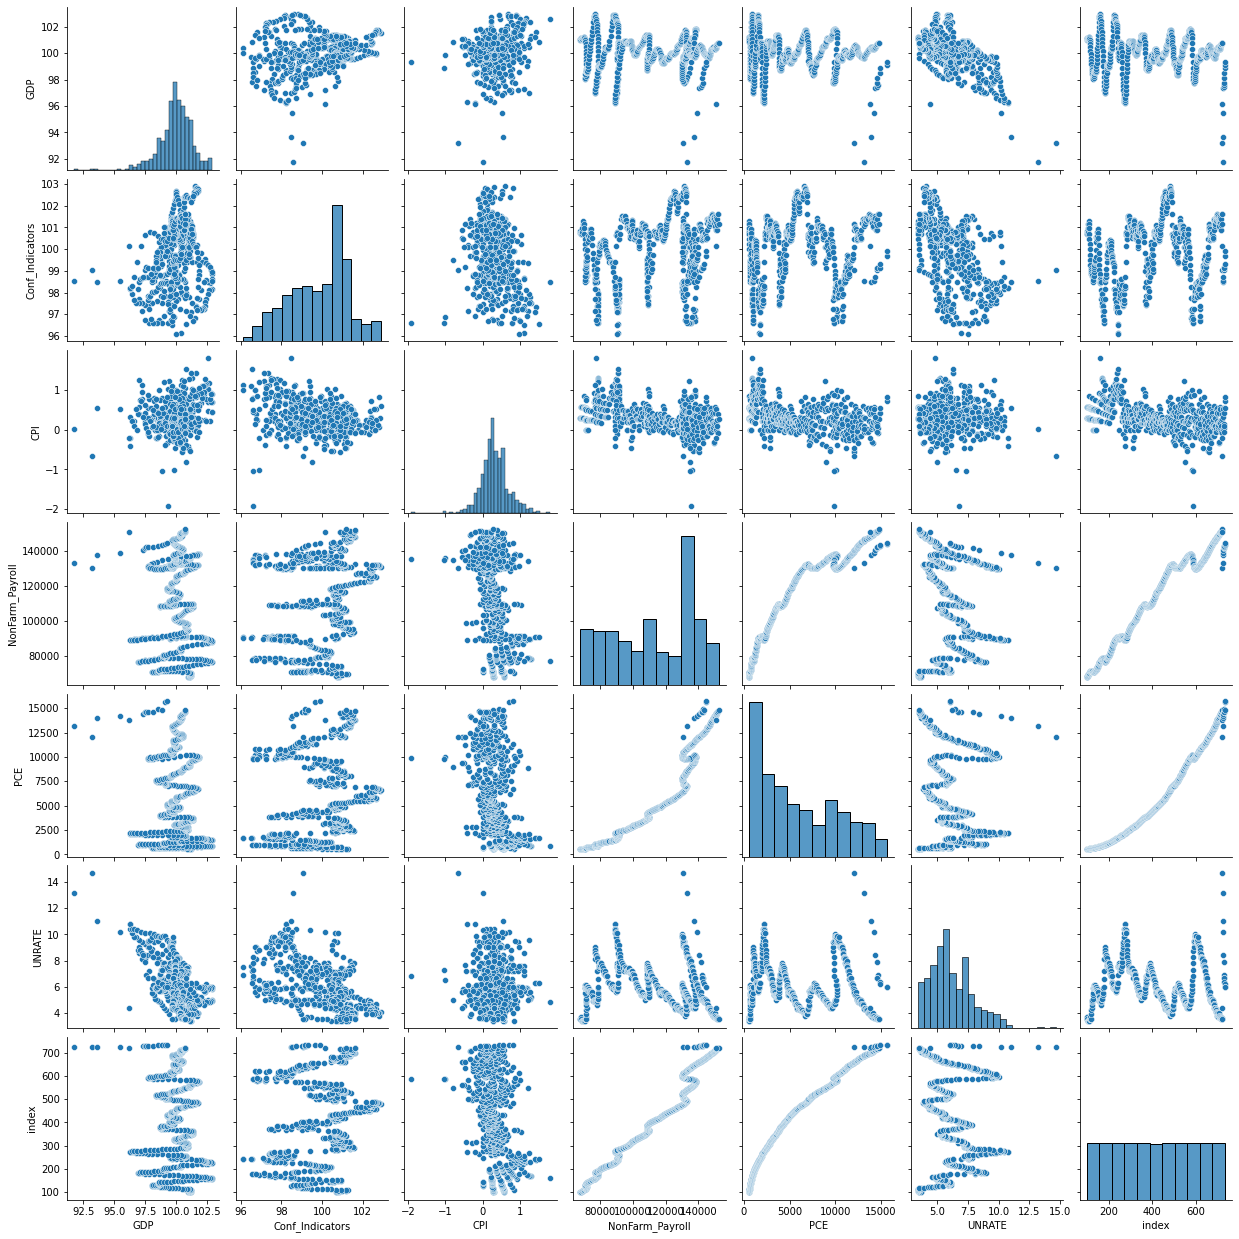

In [28]:
sns.pairplot(df)

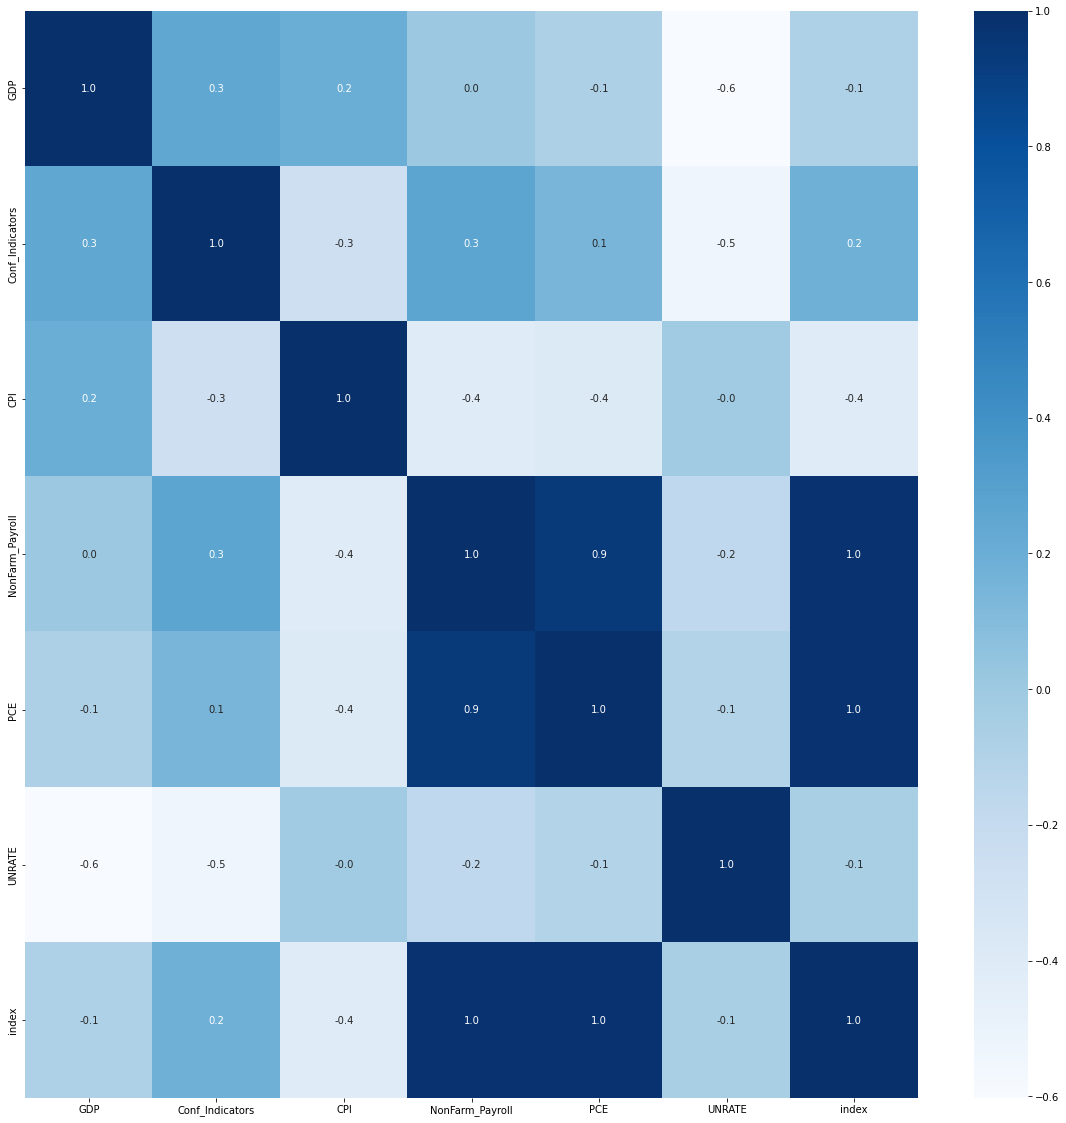

In [29]:
correlation_matrix = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, cbar=True, fmt='.1f', annot=True, cmap='Blues')
plt.savefig('Correlation Heat map')

In [30]:
normalized_df=(df-df.mean())/df.std()

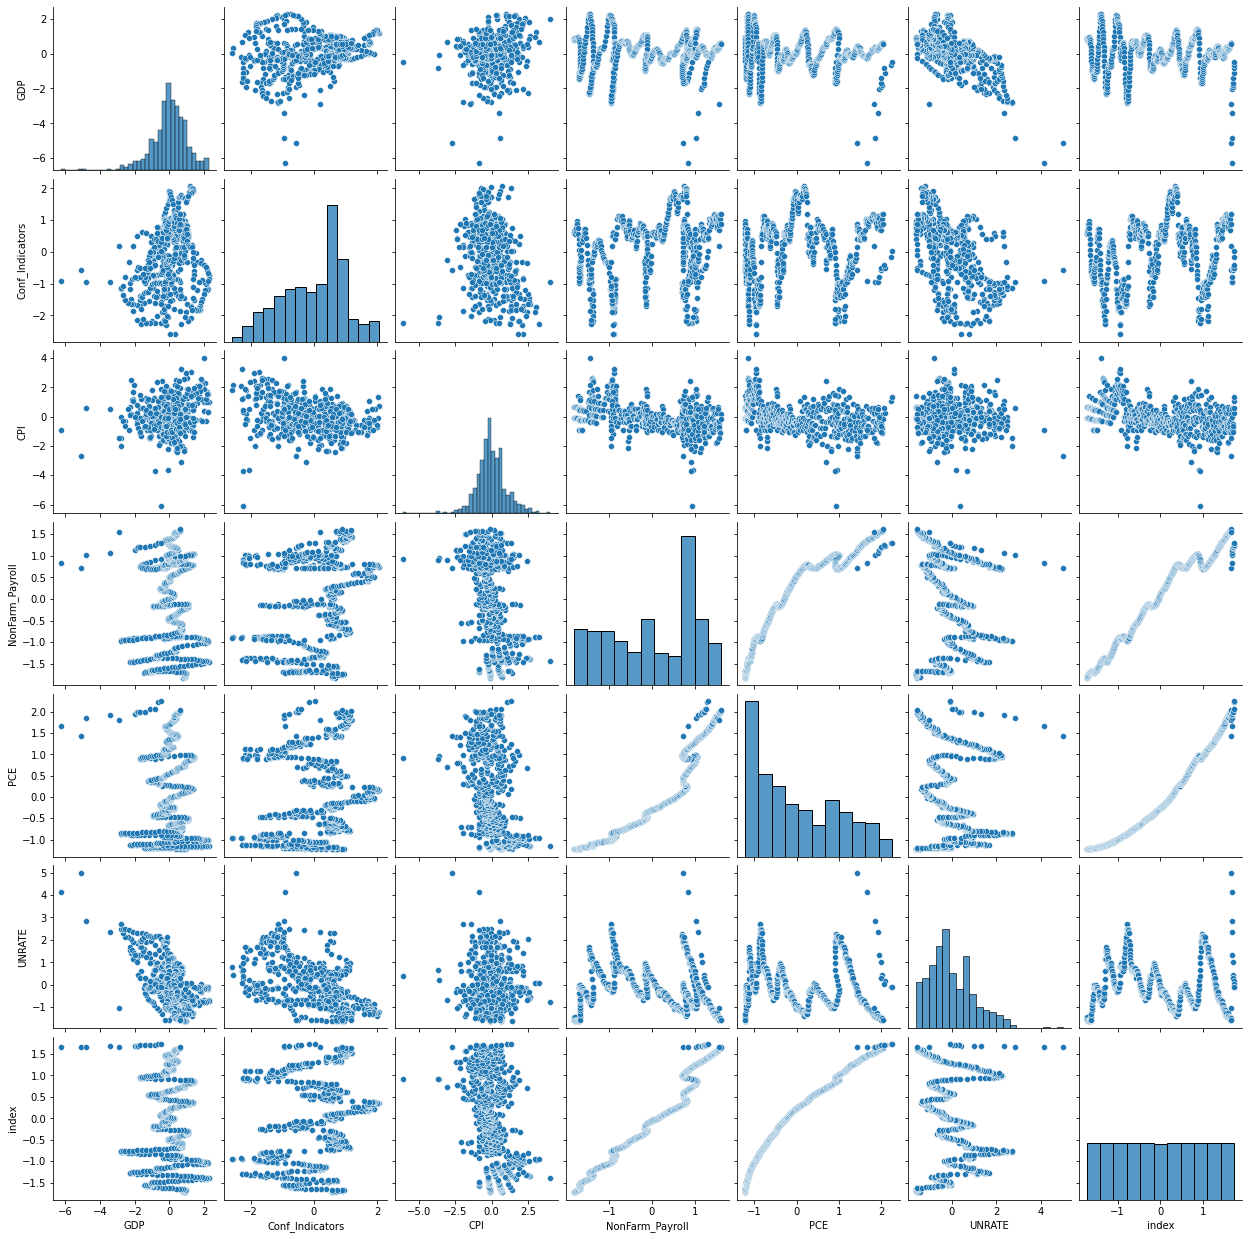

In [31]:
sns.pairplot(normalized_df)

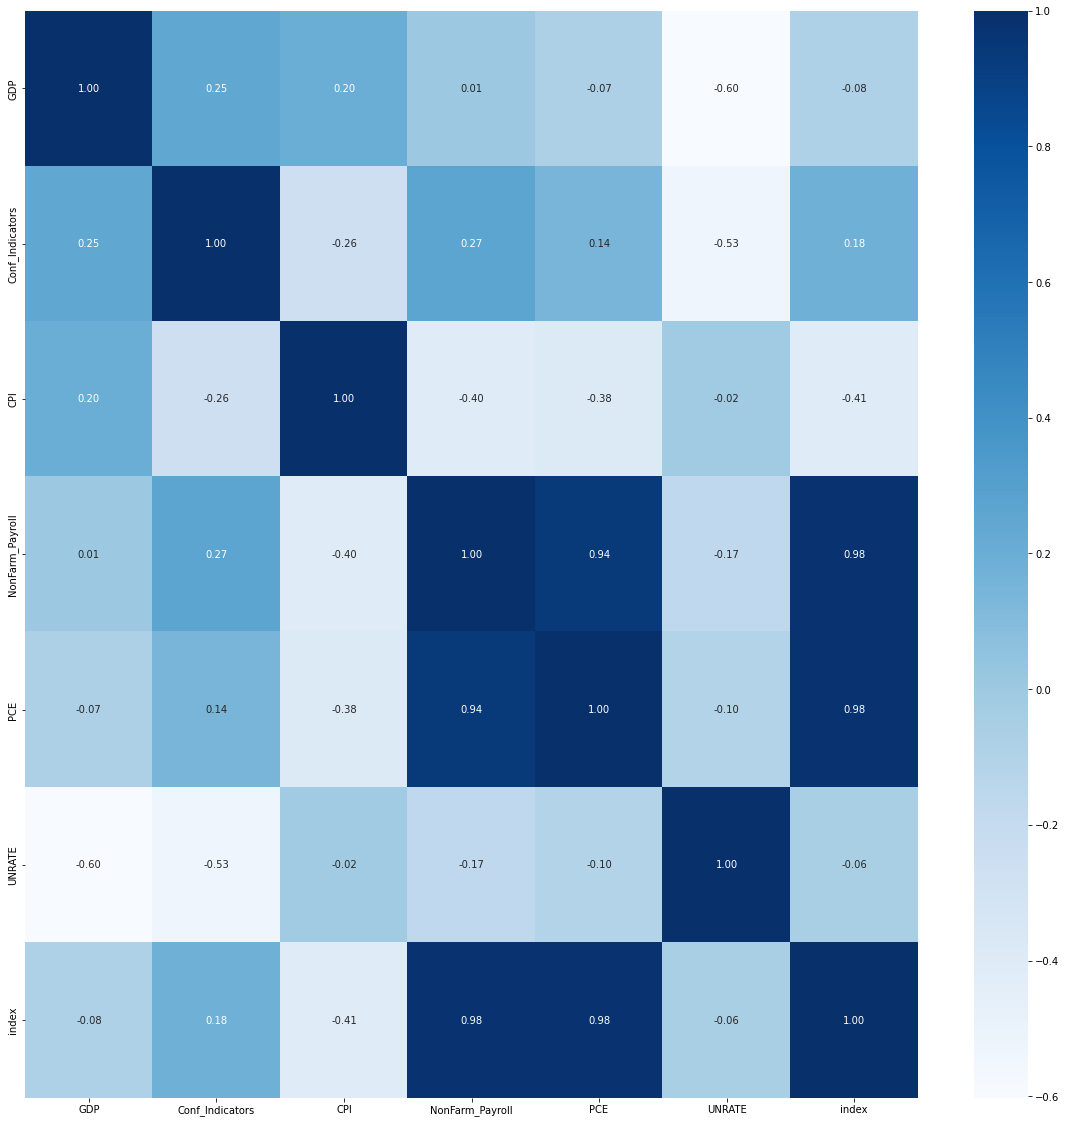

In [32]:
correlation_matrix = normalized_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, cbar=True, fmt='.2f', annot=True, cmap='Blues')
plt.savefig('Correlation Heat map')

In [33]:
df_reset = df.reset_index()
df_reset

,level_0,GDP,Conf_Indicators,CPI,NonFarm_Payroll,PCE,UNRATE,index
0,99,100.971358,100.831759,0.291545,67556,544.0,3.5,99
1,100,101.093474,100.759268,0.290698,67652,549.8,3.5,100
2,101,101.159464,100.730884,0.579710,67905,556.3,3.7,101
3,102,101.176529,100.714694,0.576369,68126,563.2,3.7,102
4,103,101.159511,100.698489,0.286533,68330,567.0,3.5,103
...,...,...,...,...,...,...,...,...
632,731,98.134520,99.144124,0.094148,142497,14571.1,6.7,731
633,732,98.523237,99.150299,0.425378,143017,14932.2,6.4,732
634,733,98.890503,99.291942,0.547438,143727,14843.2,6.2,733
635,734,99.116447,99.663634,0.708327,144431,15619.1,6.0,734


In [34]:
df_reset.drop(labels=["level_0"],axis=1,inplace=True)
df_reset

,GDP,Conf_Indicators,CPI,NonFarm_Payroll,PCE,UNRATE,index
0,100.971358,100.831759,0.291545,67556,544.0,3.5,99
1,101.093474,100.759268,0.290698,67652,549.8,3.5,100
2,101.159464,100.730884,0.579710,67905,556.3,3.7,101
3,101.176529,100.714694,0.576369,68126,563.2,3.7,102
4,101.159511,100.698489,0.286533,68330,567.0,3.5,103
...,...,...,...,...,...,...,...
632,98.134520,99.144124,0.094148,142497,14571.1,6.7,731
633,98.523237,99.150299,0.425378,143017,14932.2,6.4,732
634,98.890503,99.291942,0.547438,143727,14843.2,6.2,733
635,99.116447,99.663634,0.708327,144431,15619.1,6.0,734


In [35]:
gold_reset = gdf.reset_index()
print(gold_reset)

     index        price
0        3    37.862500
1        4    40.697826
2        5    41.142105
3        6    39.467391
4        7    39.190909
..     ...          ...
632    635  1855.955263
633    636  1866.985000
634    637  1808.175000
635    638  1718.228261
636    639  1736.250000

[637 rows x 2 columns]


In [36]:
silver_reset = sdf.reset_index()
print(silver_reset)

     index      price
0        3   2.255200
1        4   2.414957
2        5   2.478316
3        6   2.356913
4        7   2.209591
..     ...        ...
632    635  24.887381
633    636  25.896750
634    637  27.351000
635    638  25.613478
636    639  24.780000

[637 rows x 2 columns]


In [37]:
silver_reset

,index,price
0,3,2.255200
1,4,2.414957
2,5,2.478316
3,6,2.356913
4,7,2.209591
...,...,...
632,635,24.887381
633,636,25.896750
634,637,27.351000
635,638,25.613478


In [38]:
gold_reset.drop(labels=["index"],axis=1,inplace=True)

In [39]:
gold_df = pd.concat([df_reset, gold_reset],axis=1)

In [40]:
gold_df

,GDP,Conf_Indicators,CPI,NonFarm_Payroll,PCE,UNRATE,index,price
0,100.971358,100.831759,0.291545,67556,544.0,3.5,99,37.862500
1,101.093474,100.759268,0.290698,67652,549.8,3.5,100,40.697826
2,101.159464,100.730884,0.579710,67905,556.3,3.7,101,41.142105
3,101.176529,100.714694,0.576369,68126,563.2,3.7,102,39.467391
4,101.159511,100.698489,0.286533,68330,567.0,3.5,103,39.190909
...,...,...,...,...,...,...,...,...
632,98.134520,99.144124,0.094148,142497,14571.1,6.7,731,1855.955263
633,98.523237,99.150299,0.425378,143017,14932.2,6.4,732,1866.985000
634,98.890503,99.291942,0.547438,143727,14843.2,6.2,733,1808.175000
635,99.116447,99.663634,0.708327,144431,15619.1,6.0,734,1718.228261


In [41]:
normalized_gold_df=(gold_df-gold_df.mean())/gold_df.std()
normalized_gold_df

,GDP,Conf_Indicators,CPI,NonFarm_Payroll,PCE,UNRATE,index,price
0,0.756921,0.654139,-0.086673,-1.816580,-1.227104,-1.548876,-1.727976,-1.105717
1,0.849651,0.604532,-0.088981,-1.812703,-1.225771,-1.548876,-1.722542,-1.099801
2,0.899761,0.585108,0.698037,-1.802485,-1.224277,-1.431935,-1.717108,-1.098874
3,0.912719,0.574029,0.688939,-1.793560,-1.222692,-1.431935,-1.711674,-1.102368
4,0.899796,0.562940,-0.100322,-1.785321,-1.221819,-1.548876,-1.706240,-1.102945
...,...,...,...,...,...,...,...,...
632,-1.397250,-0.500742,-0.624212,1.210062,1.996370,0.322185,1.706240,2.687754
633,-1.102076,-0.496517,0.277772,1.231063,2.079352,0.146773,1.711674,2.710767
634,-0.823189,-0.399588,0.610157,1.259738,2.058899,0.029832,1.717108,2.588060
635,-0.651617,-0.145231,1.048279,1.288170,2.237204,-0.087109,1.722542,2.400385


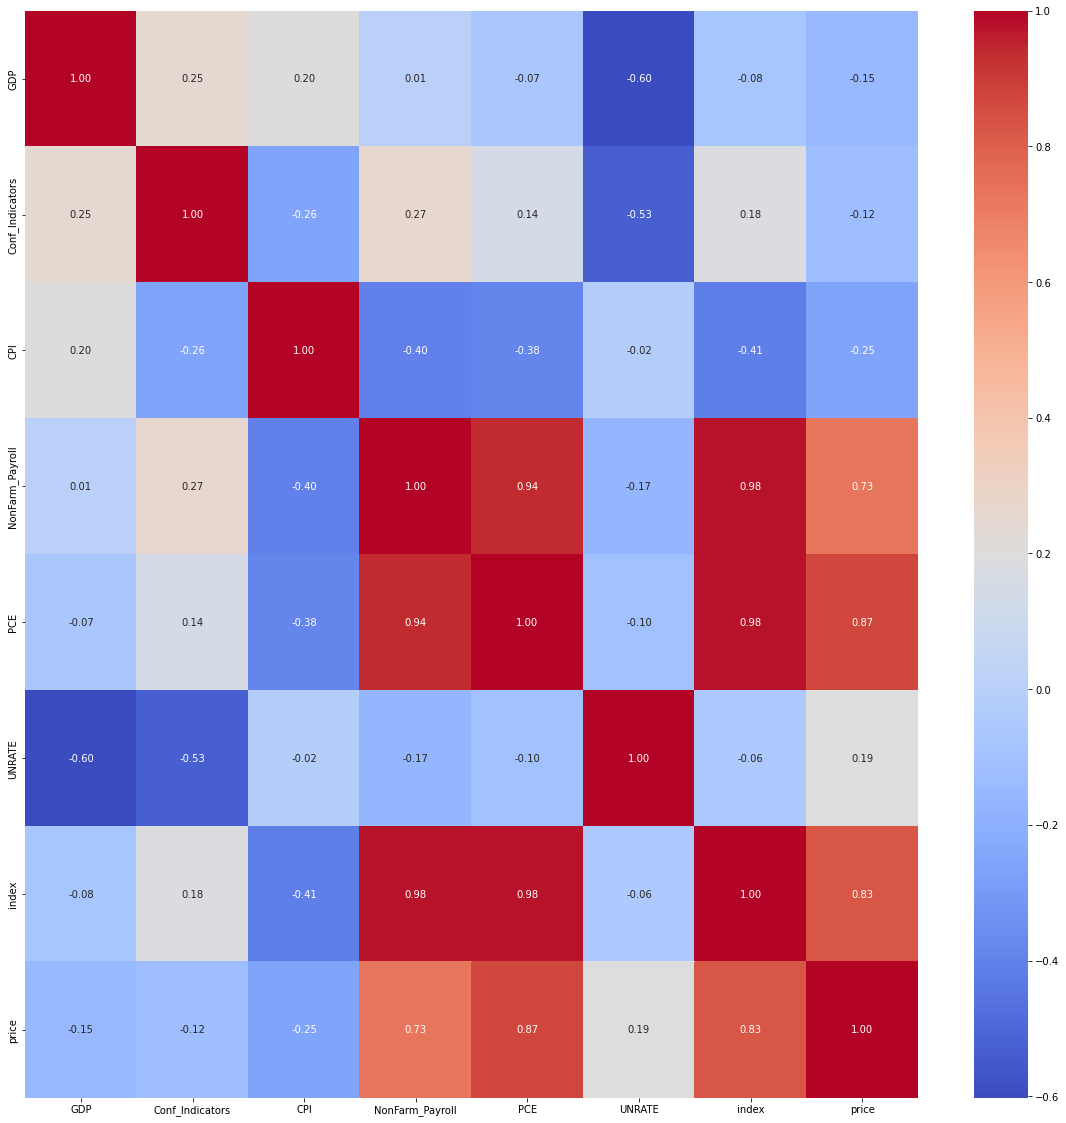

In [42]:
correlation_matrix = normalized_gold_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, cbar=True, fmt='.2f', annot=True, cmap='coolwarm')
plt.savefig('Correlation Heat map')

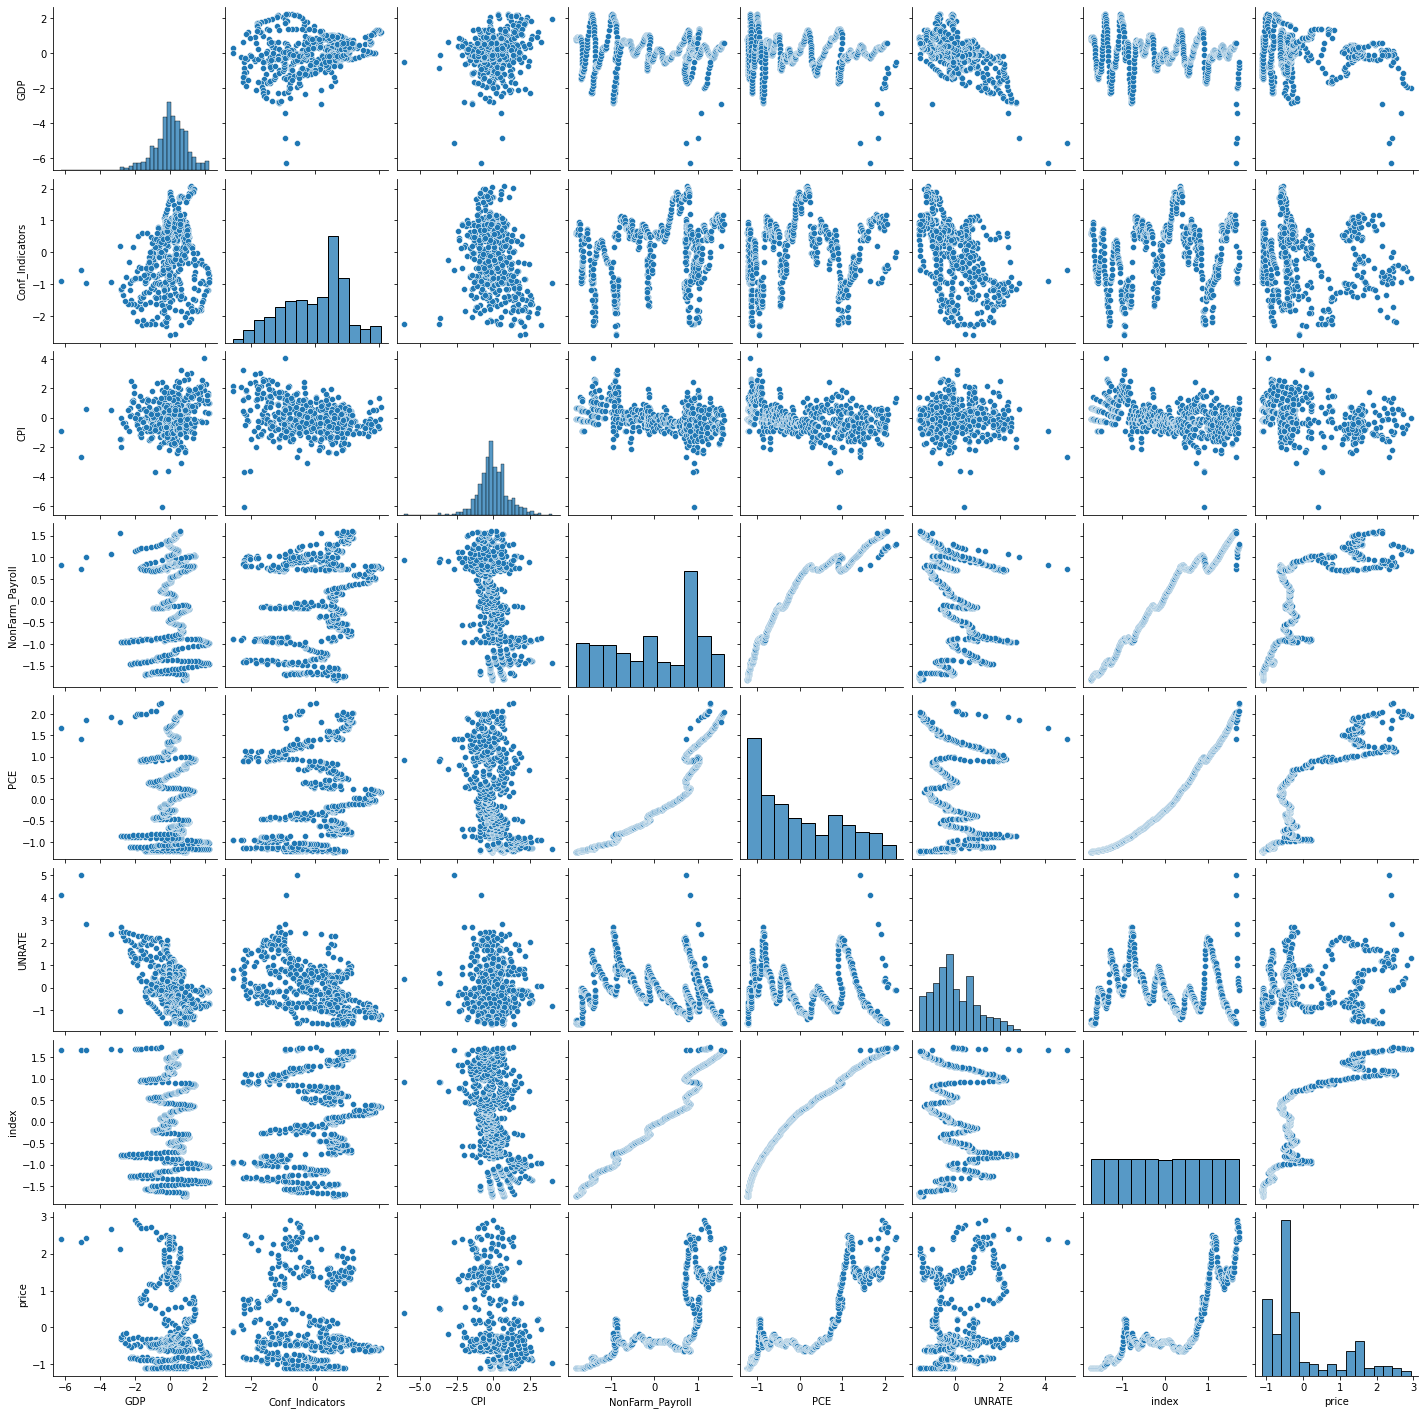

In [43]:
sns.pairplot(normalized_gold_df)

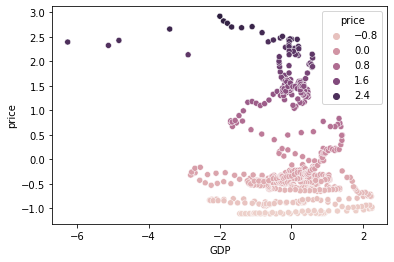

In [44]:
sns.scatterplot(x=normalized_gold_df['GDP'], y=normalized_gold_df['price'], hue = normalized_gold_df['price'])

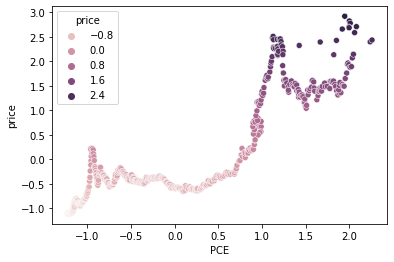

In [45]:
sns.scatterplot(x=normalized_gold_df['PCE'], y=normalized_gold_df['price'], hue = normalized_gold_df['price'])

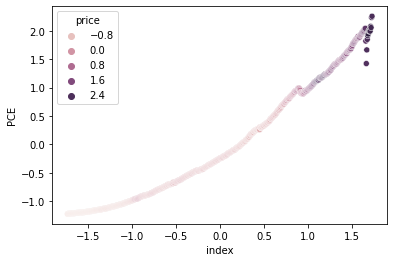

In [46]:
sns.scatterplot(x=normalized_gold_df['index'], y=normalized_gold_df['PCE'], hue=normalized_gold_df["price"])#, style=normalized_gold_df["price"])

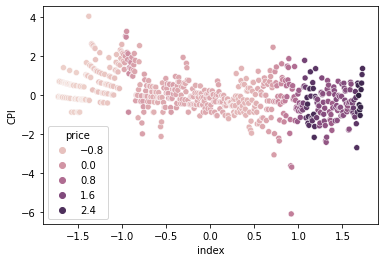

In [47]:
sns.scatterplot(x=normalized_gold_df['index'], y=normalized_gold_df['CPI'], hue=normalized_gold_df["price"])#, style=normalized_gold_df["price"])

In [48]:
silver_reset.drop(labels=["index"],axis=1,inplace=True)

In [49]:
silver_df = pd.concat([df_reset, silver_reset],axis=1)

In [50]:
silver_df

,GDP,Conf_Indicators,CPI,NonFarm_Payroll,PCE,UNRATE,index,price
0,100.971358,100.831759,0.291545,67556,544.0,3.5,99,2.255200
1,101.093474,100.759268,0.290698,67652,549.8,3.5,100,2.414957
2,101.159464,100.730884,0.579710,67905,556.3,3.7,101,2.478316
3,101.176529,100.714694,0.576369,68126,563.2,3.7,102,2.356913
4,101.159511,100.698489,0.286533,68330,567.0,3.5,103,2.209591
...,...,...,...,...,...,...,...,...
632,98.134520,99.144124,0.094148,142497,14571.1,6.7,731,24.887381
633,98.523237,99.150299,0.425378,143017,14932.2,6.4,732,25.896750
634,98.890503,99.291942,0.547438,143727,14843.2,6.2,733,27.351000
635,99.116447,99.663634,0.708327,144431,15619.1,6.0,734,25.613478


In [51]:
normalized_silver_df=(silver_df-silver_df.mean())/silver_df.std()
normalized_silver_df

,GDP,Conf_Indicators,CPI,NonFarm_Payroll,PCE,UNRATE,index,price
0,0.756921,0.654139,-0.086673,-1.816580,-1.227104,-1.548876,-1.727976,-0.945263
1,0.849651,0.604532,-0.088981,-1.812703,-1.225771,-1.548876,-1.722542,-0.924791
2,0.899761,0.585108,0.698037,-1.802485,-1.224277,-1.431935,-1.717108,-0.916671
3,0.912719,0.574029,0.688939,-1.793560,-1.222692,-1.431935,-1.711674,-0.932229
4,0.899796,0.562940,-0.100322,-1.785321,-1.221819,-1.548876,-1.706240,-0.951108
...,...,...,...,...,...,...,...,...
632,-1.397250,-0.500742,-0.624212,1.210062,1.996370,0.322185,1.706240,1.954987
633,-1.102076,-0.496517,0.277772,1.231063,2.079352,0.146773,1.711674,2.084335
634,-0.823189,-0.399588,0.610157,1.259738,2.058899,0.029832,1.717108,2.270693
635,-0.651617,-0.145231,1.048279,1.288170,2.237204,-0.087109,1.722542,2.048034


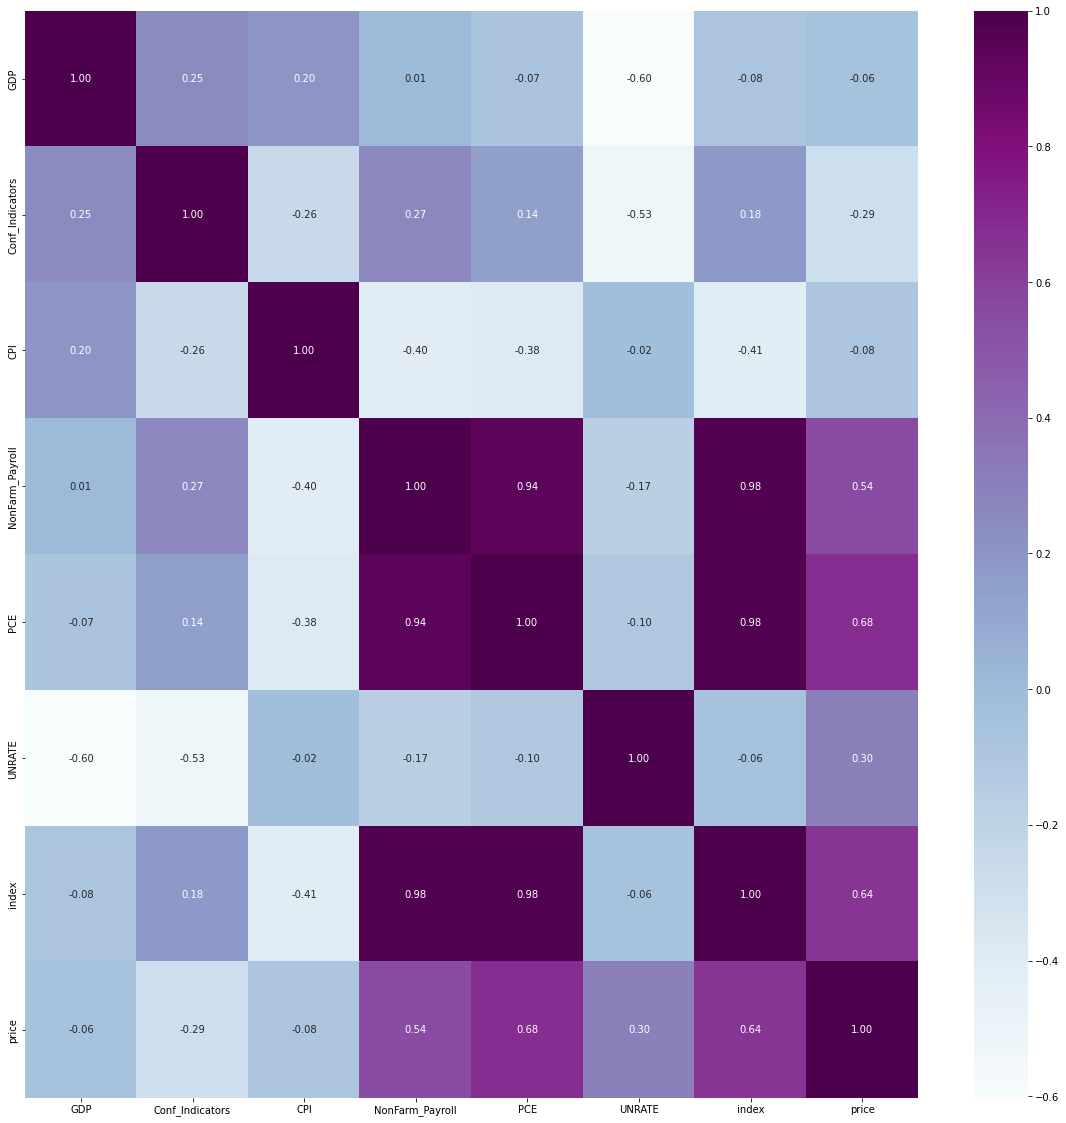

In [52]:
correlation_matrix = normalized_silver_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, cbar=True, fmt='.2f', annot=True, cmap='BuPu')
plt.savefig('Correlation Heat map')

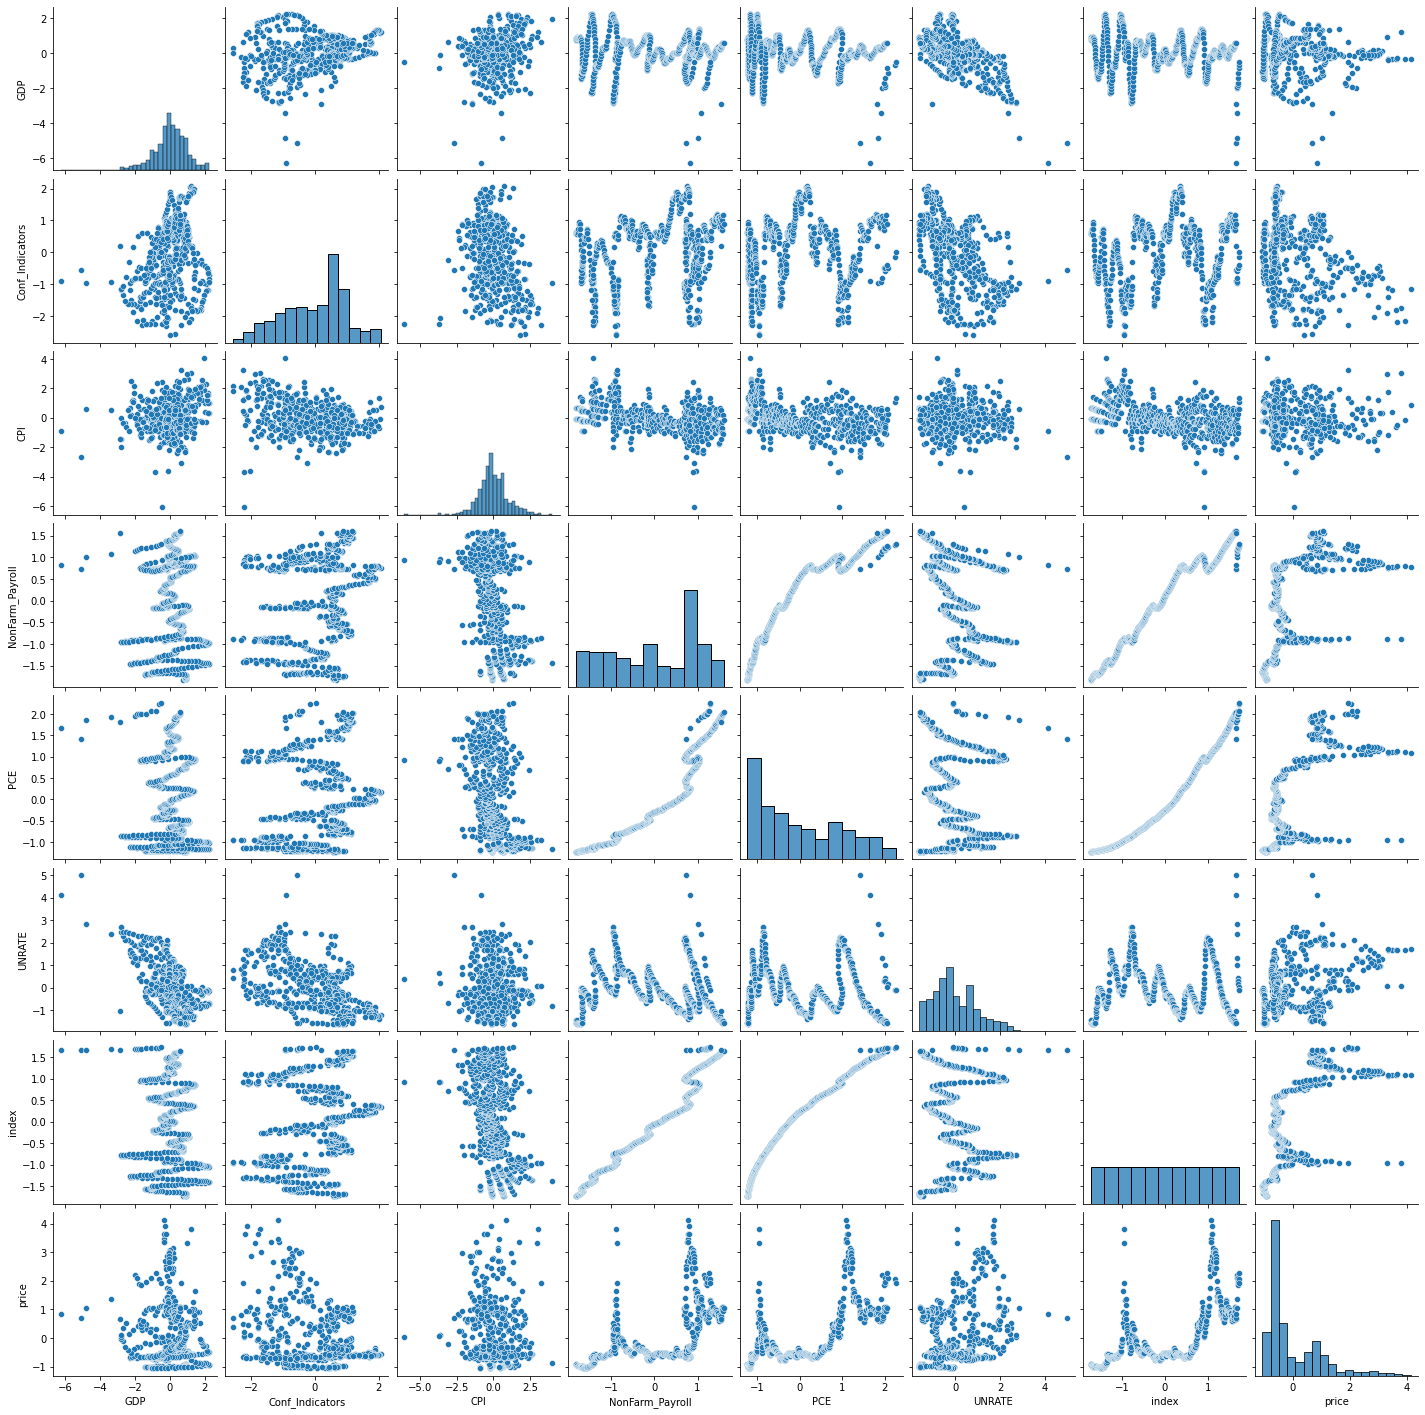

In [53]:
sns.pairplot(normalized_silver_df)

# Models

The 4 models we ran are Linear regression (baseline), XGBoost, Elastic Net, and Dense Feedforward Neural Network. 

In [54]:
def shuffle(X, y):
    #shuffles the indices of X and y so that the label remains the same for each data point
    shuffler = np.random.permutation(len(y))
    x_new = X[shuffler]
    y_new = y[shuffler]
    return x_new, y_new

In [55]:
def runLinReg(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    linReg = LinearRegression().fit(X_train, y_train)
    score = linReg.score(X_test, y_test)
    coefs = linReg.coef_
    intercept = linReg.intercept_
    pred = np.array(coefs[0])@X_test.T + intercept
    mse = mean_squared_error(pred, y_test)
    print("Linear Regression MSE: ", mse)
    print(score)
    print(coefs)
    return mse

In [56]:
def runXGBoost(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    reg = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3, objective='reg:squarederror'
    )
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("XGBoost MSE: ", mse)
    return mse

In [57]:
def runElasticNet(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    model = ElasticNet(alpha=0.001, l1_ratio=1, max_iter=5000).fit(X_train, y_train)
    score = model.score(X_test, y_test)
    coefs = model.coef_
    intercept = model.intercept_
    pred = np.array(coefs)@X_test.T + intercept
    mse = mean_squared_error(pred, y_test)
    print("Elastic Net MSE: ", mse)
    print(score)
    print(coefs)
    print(intercept)
    return mse

The next two cells contain the code for the neural net architecture and training loop. The neural net is made up of 6 fully connected linear layers including the in and out layers and a dropout layer with p=0.1 after the fifth layer. The dropout layer only slightly improved the accuracy, but we felt it was important to prevent any overfitting. We testing the model with our data using similar architectures with deeper, wider, shallower, and narrower layers but this architecture had the best performance. We selected the learning rate by training the model with lr=[1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 7.5e-4, 5e-4, 2.5e-4, 1e-4] and the best results used lr=2.5e-4. We also tried using stochastic gradient descent and Adam; Adam was a much better optimizer for our model. 

In [58]:
class NeuralNet(nn.Module):
  def __init__(self, input, hiddensize = 10):
    super().__init__() 
    self.in_layer = nn.Linear(input, hiddensize)
    self.dense1 = nn.Linear(hiddensize, 20)
    self.dense2 = nn.Linear(20, 50)
    self.dense3 = nn.Linear(50, 50)
    self.dense4 = nn.Linear(50, hiddensize)
    self.out_layer = nn.Linear(hiddensize, 1)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    x = self.relu(self.in_layer(x))
    x = self.relu(self.dense1(x))
    x = self.relu(self.dense2(x))
    x = self.relu(self.dense3(x))
    x = self.dropout(x)
    x = self.relu(self.dense4(x))
    x = self.out_layer(x)
    return x

In [59]:
def runNeuralNet(X_nn, y_nn, title):
  _, n  = X_nn.shape

  X_nn = X_nn.astype(np.float32)
  y_nn = y_nn.astype(np.float32)

  X_train, X_test, y_train, y_test = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)

  X_train = torch.from_numpy(X_train)
  X_test = torch.from_numpy(X_test)
  y_train = torch.from_numpy(y_train)
  y_test = torch.from_numpy(y_test)

  start_time = time.time()
  epochs = 100
  input_size = n
  hidden_size = 10
  model = NeuralNet(input_size, hidden_size)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=2.5e-4) 
  train_mse = []
  # training iterations
  for epoch in range(epochs):
      running_loss = 0
      for i in range(len(X_train)-1):
          # zero gradient
          optimizer.zero_grad()
          # forward path
          y_predicted = model(X_train[i])
          loss = criterion(y_predicted, y_train[i])
          running_loss += loss.item()
          # backpropagating
          loss.backward()
          # optimizes the weights
          optimizer.step()
      train_mse.append(running_loss)
      if (epoch+1) % 3 == 0:
          print(f'epoch: {epoch+1}, loss: {running_loss:.4f}')

  # # Validating model
  model.eval()
  validation_loss = 0
  for i in range(len(X_test)-1):
      outputs = model(X_test[i])
      loss = criterion(outputs, y_test[i])
      # print("loss increment: ", loss.item())
      validation_loss+=loss.item()
  print("time: ", time.time()-start_time)
  print("Validation Loss: ", validation_loss/(len(X_test)-1))
  plt.plot(np.linspace(1, epochs, epochs), train_mse, label='Train')
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('L2 loss')
  # plt.savefig("nnLossCurveGold.png")
  plt.show()

# With Index 
## Without Log 

In this part, we run our models with the index feature and without taking the log of the labels before standardizing them. The index feature represents the date that corresponds with the features in the dataset and the price in the labels. The index is an integer that represents the number of days since the first day that the data set begins. We considered removing this as a feature since the number of days since April 1, 1968 should not necessarily be an economic indicator that can predict the price of gold and silver. 
For some of these runs, we took the log of the labels before standardizing them with 0 mean and 1 variance because the data ranges from about 30 to 1500 which resulted in a standard deviation of about 478. We thought that with such a high variance, it the model would have a difficult time with any linear models. Taking the log of the labels would significantly reduce the variance which may result in better accuracy. Even though the error was reduced, that could just be because the values of the labels are smaller resulting in lower numbers as part of the error calculation so it is difficult to directly compare the accuracy of the models with and without taking the log. 

### Gold Prices Dataset

In [60]:
gold_df

,GDP,Conf_Indicators,CPI,NonFarm_Payroll,PCE,UNRATE,index,price
0,100.971358,100.831759,0.291545,67556,544.0,3.5,99,37.862500
1,101.093474,100.759268,0.290698,67652,549.8,3.5,100,40.697826
2,101.159464,100.730884,0.579710,67905,556.3,3.7,101,41.142105
3,101.176529,100.714694,0.576369,68126,563.2,3.7,102,39.467391
4,101.159511,100.698489,0.286533,68330,567.0,3.5,103,39.190909
...,...,...,...,...,...,...,...,...
632,98.134520,99.144124,0.094148,142497,14571.1,6.7,731,1855.955263
633,98.523237,99.150299,0.425378,143017,14932.2,6.4,732,1866.985000
634,98.890503,99.291942,0.547438,143727,14843.2,6.2,733,1808.175000
635,99.116447,99.663634,0.708327,144431,15619.1,6.0,734,1718.228261


In [61]:
#convert dataframes to numpy arrays
y1_std = gdf.copy()
y2_std = sdf.copy()
X = df.to_numpy()
y1_std = y1_std.to_numpy()
y2_std = y2_std.to_numpy()

In [62]:
#standardize the data with mean 0 and stdev 1
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

In [63]:
y1_std -= np.mean(y1_std, axis=0)
y1_std /= np.std(y1_std, axis=0)

In [64]:
#run linear regression model
lr_wi_wolg_mse = runLinReg(X, y1_std)

Linear Regression MSE:  0.06341781905693214
0.9437079461660705
[[ 0.15121744 -0.09008132  0.05037956 -2.7393354  -0.15619759 -0.02828793
   3.71926978]]


In [65]:
#run elastic net model
en_wi_wolg_mse = runElasticNet(X, y1_std)

Elastic Net MSE:  0.0628377462001593
0.9442228407645704
[ 0.15005421 -0.0819036   0.04874435 -2.37699185  0.11141402  0.02859843
  3.10034387]
[0.00307861]


In [66]:
#run xgboost model
xg_wi_wolg_mse = runXGBoost(X, y1_std)

XGBoost MSE:  0.004253840597289116


epoch: 3, loss: 52.2514
epoch: 6, loss: 33.7954
epoch: 9, loss: 29.2215
epoch: 12, loss: 26.0613
epoch: 15, loss: 23.9038
epoch: 18, loss: 19.8354
epoch: 21, loss: 21.0117
epoch: 24, loss: 20.4176
epoch: 27, loss: 15.2615
epoch: 30, loss: 16.5371
epoch: 33, loss: 14.8935
epoch: 36, loss: 14.2284
epoch: 39, loss: 12.6491
epoch: 42, loss: 14.0388
epoch: 45, loss: 12.1111
epoch: 48, loss: 12.4131
epoch: 51, loss: 11.7929
epoch: 54, loss: 11.0703
epoch: 57, loss: 9.8431
epoch: 60, loss: 10.6767
epoch: 63, loss: 10.0700
epoch: 66, loss: 9.9971
epoch: 69, loss: 11.0554
epoch: 72, loss: 8.4853
epoch: 75, loss: 10.1770
epoch: 78, loss: 8.6013
epoch: 81, loss: 8.7590
epoch: 84, loss: 6.7263
epoch: 87, loss: 9.4232
epoch: 90, loss: 7.4539
epoch: 93, loss: 7.5277
epoch: 96, loss: 7.7251
epoch: 99, loss: 7.4533
time:  89.05585622787476
Validation Loss:  0.009080767606187548


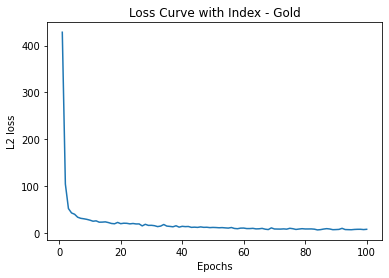

In [67]:
runNeuralNet(X, y1_std, 'Loss Curve with Index - Gold')

### Silver Prices Dataset

In [68]:
y2_std -= np.mean(y2_std, axis=0)
y2_std /= np.std(y2_std, axis=0)

In [69]:
#run linear regression model
lr_wi_wolg_mse_sil = runLinReg(X, y2_std)

Linear Regression MSE:  0.19838602548573864
0.8186695354256203
[[ 0.35209767 -0.15458092  0.11311686 -1.18744273  0.83494747  0.38843434
   1.10325911]]


In [70]:
#run elastic net model
en_wi_wolg_mse_sil = runElasticNet(X, y2_std)

Elastic Net MSE:  0.19704828598893065
0.8198922673385247
[ 0.3509031  -0.14650006  0.11148856 -0.82803811  1.0999903   0.44479092
  0.48972972]
[0.00634196]


In [71]:
#run xgboost model
xg_wi_wolg_mse_sil = runXGBoost(X, y2_std)

XGBoost MSE:  0.028611276517329944


epoch: 3, loss: 136.0040
epoch: 6, loss: 92.0286
epoch: 9, loss: 78.2820
epoch: 12, loss: 69.6831
epoch: 15, loss: 57.8370
epoch: 18, loss: 57.7735
epoch: 21, loss: 50.9154
epoch: 24, loss: 47.0132
epoch: 27, loss: 46.7678
epoch: 30, loss: 43.0920
epoch: 33, loss: 40.3433
epoch: 36, loss: 37.8480
epoch: 39, loss: 37.4601
epoch: 42, loss: 34.8991
epoch: 45, loss: 33.4433
epoch: 48, loss: 29.1318
epoch: 51, loss: 31.3854
epoch: 54, loss: 30.4843
epoch: 57, loss: 30.5815
epoch: 60, loss: 27.3860
epoch: 63, loss: 25.5795
epoch: 66, loss: 25.7605
epoch: 69, loss: 26.2779
epoch: 72, loss: 27.1268
epoch: 75, loss: 21.2432
epoch: 78, loss: 21.9934
epoch: 81, loss: 25.2276
epoch: 84, loss: 22.1342
epoch: 87, loss: 22.4956
epoch: 90, loss: 18.0729
epoch: 93, loss: 22.8611
epoch: 96, loss: 20.5544
epoch: 99, loss: 19.7572
time:  80.9036819934845
Validation Loss:  0.09196862541818794


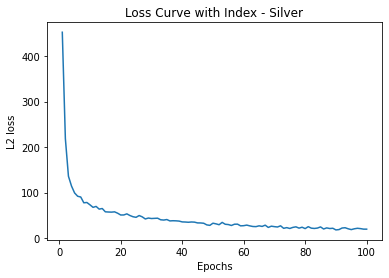

In [72]:
runNeuralNet(X, y2_std, 'Loss Curve with Index - Silver')

# With Index
## With Log

In [73]:
#Take log of the data
y1_log = gdf.copy()
#print(y1_log)
y1_log = y1_log.to_numpy()
y2_log = sdf.copy()
y2_log = y2_log.to_numpy()
#print(y1_log)
#print(y2_log)

In [74]:
y1_log = np.log(y1_log)
y2_log = np.log(y2_log)

In [75]:
y1_log -= np.mean(y1_log, axis=0)
y1_log /= np.std(y1_log, axis=0)
y2_log -= np.mean(y2_log, axis=0)
y2_log /= np.std(y2_log, axis=0)

### Gold Prices Dataset

In [76]:
#run linear regression model
lr_wi_wlg_mse = runLinReg(X, y1_log)

Linear Regression MSE:  0.10965310999054247
0.8973958136097306
[[ 0.21754947 -0.09103251  0.09311985 -1.17196667 -1.17977049  0.20189451
   3.26291597]]


In [77]:
#run elastic net model
en_wi_wlg_mse = runElasticNet(X, y1_log) #5000 iterations

Elastic Net MSE:  0.11039901159948051
0.8966978614247094
[ 0.22100847 -0.07104134  0.09061183 -0.52502672 -0.63536221  0.31376585
  2.09383626]
[0.00060003]


In [78]:
#run elastic net model
#en_wi_wlg_mse = runElasticNet(X, y1_log) #10000 iterations

In [79]:
#run xgboost model
xg_wi_wlg_mse = runXGBoost(X, y1_log)

XGBoost MSE:  0.0030155923774074804


epoch: 3, loss: 138.1879
epoch: 6, loss: 41.9633
epoch: 9, loss: 26.3399
epoch: 12, loss: 22.2524
epoch: 15, loss: 19.8972
epoch: 18, loss: 18.0750
epoch: 21, loss: 14.5549
epoch: 24, loss: 13.4868
epoch: 27, loss: 13.5176
epoch: 30, loss: 12.9823
epoch: 33, loss: 13.6790
epoch: 36, loss: 10.9809
epoch: 39, loss: 9.9560
epoch: 42, loss: 13.2983
epoch: 45, loss: 10.6455
epoch: 48, loss: 9.8255
epoch: 51, loss: 9.5832
epoch: 54, loss: 10.9597
epoch: 57, loss: 8.8158
epoch: 60, loss: 9.7943
epoch: 63, loss: 10.3975
epoch: 66, loss: 9.1011
epoch: 69, loss: 10.5523
epoch: 72, loss: 8.3191
epoch: 75, loss: 7.6547
epoch: 78, loss: 7.8980
epoch: 81, loss: 8.7354
epoch: 84, loss: 8.6396
epoch: 87, loss: 7.4680
epoch: 90, loss: 6.7502
epoch: 93, loss: 7.0228
epoch: 96, loss: 8.4083
epoch: 99, loss: 8.0429
time:  82.63029146194458
Validation Loss:  0.013008026916581662


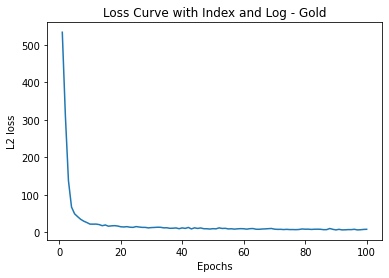

In [80]:
runNeuralNet(X, y1_log, 'Loss Curve with Index and Log - Gold')

### Silver Prices Dataset

In [81]:
#run linear regression model
lr_wi_wlg_mse_sil = runLinReg(X, y2_log)

Linear Regression MSE:  0.17693310479279017
0.8322456891376724
[[ 0.36791686 -0.08221643  0.14159887  0.03338401  0.85947917  0.59364062
  -0.00603022]]


In [82]:
#run elastic net model
en_wi_wlg_mse_sil = runElasticNet(X, y2_log)

Elastic Net MSE:  0.1767555059119561
0.8324140746859797
[ 0.36530183 -0.08224346  0.14046851  0.0188035   0.84796174  0.58862496
  0.01763364]
[0.00647765]


In [83]:
#run xgboost model
xg_wi_wlg_mse_sil = runXGBoost(X, y2_log)

XGBoost MSE:  0.014764217974091602


epoch: 3, loss: 161.3166
epoch: 6, loss: 95.4429
epoch: 9, loss: 71.7645
epoch: 12, loss: 57.3660
epoch: 15, loss: 51.3632
epoch: 18, loss: 45.0373
epoch: 21, loss: 38.1059
epoch: 24, loss: 36.2790
epoch: 27, loss: 34.5298
epoch: 30, loss: 29.4299
epoch: 33, loss: 26.5668
epoch: 36, loss: 25.5803
epoch: 39, loss: 25.6528
epoch: 42, loss: 24.5570
epoch: 45, loss: 22.6513
epoch: 48, loss: 22.2793
epoch: 51, loss: 22.3113
epoch: 54, loss: 22.1801
epoch: 57, loss: 21.8498
epoch: 60, loss: 20.3633
epoch: 63, loss: 19.8071
epoch: 66, loss: 19.3071
epoch: 69, loss: 18.6135
epoch: 72, loss: 18.8263
epoch: 75, loss: 19.0982
epoch: 78, loss: 16.8891
epoch: 81, loss: 17.8750
epoch: 84, loss: 16.0011
epoch: 87, loss: 16.1317
epoch: 90, loss: 16.6307
epoch: 93, loss: 15.2615
epoch: 96, loss: 16.6507
epoch: 99, loss: 14.6113
time:  87.12323212623596
Validation Loss:  0.03310393379372075


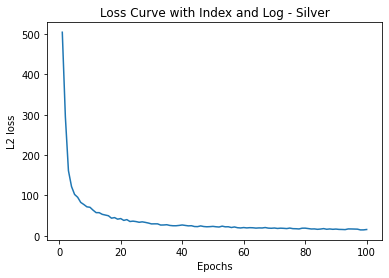

In [84]:
runNeuralNet(X, y2_log, 'Loss Curve with Index and Log - Silver')

# Without Index
## Without Log 

In [85]:
df_wo_index = df.copy()

In [86]:
df_wo_index.drop(labels=["index"], axis=1, inplace=True)
df_wo_index

,GDP,Conf_Indicators,CPI,NonFarm_Payroll,PCE,UNRATE
99,100.971358,100.831759,0.291545,67556,544.0,3.5
100,101.093474,100.759268,0.290698,67652,549.8,3.5
101,101.159464,100.730884,0.579710,67905,556.3,3.7
102,101.176529,100.714694,0.576369,68126,563.2,3.7
103,101.159511,100.698489,0.286533,68330,567.0,3.5
...,...,...,...,...,...,...
731,98.134520,99.144124,0.094148,142497,14571.1,6.7
732,98.523237,99.150299,0.425378,143017,14932.2,6.4
733,98.890503,99.291942,0.547438,143727,14843.2,6.2
734,99.116447,99.663634,0.708327,144431,15619.1,6.0


In [87]:
X_wo_index = df_wo_index.copy()
X_wo_index = X_wo_index.to_numpy()

In [88]:
X_wo_index_std = X_wo_index.copy()

In [89]:
X_wo_index_std -= np.mean(X_wo_index_std, axis=0)
X_wo_index_std /= np.std(X_wo_index_std, axis=0)

### Gold Prices Dataset

In [90]:
#run linear regression model
lr_woi_wolg_mse = runLinReg(X_wo_index_std, y1_std)

Linear Regression MSE:  0.0808380708183053
0.9282450720948021
[[ 0.16977952 -0.02733502  0.04334385 -0.68205217  1.57508331  0.33471792]]


In [91]:
#run elastic net model
en_woi_wolg_mse = runElasticNet(X_wo_index_std, y1_std)

Elastic Net MSE:  0.0806440154263799
0.9284173229973319
[ 0.16548086 -0.02966471  0.04287987 -0.66159178  1.55410733  0.33116638]
[-0.00413552]


In [92]:
#run xgboost model
xg_woi_wolg_mse = runXGBoost(X_wo_index_std, y1_std)

XGBoost MSE:  0.005222681309776819


epoch: 3, loss: 205.0502
epoch: 6, loss: 112.3688
epoch: 9, loss: 70.6441
epoch: 12, loss: 45.4010
epoch: 15, loss: 37.3820
epoch: 18, loss: 31.6063
epoch: 21, loss: 27.8533
epoch: 24, loss: 23.5765
epoch: 27, loss: 20.2907
epoch: 30, loss: 21.3061
epoch: 33, loss: 17.5189
epoch: 36, loss: 18.8125
epoch: 39, loss: 14.3985
epoch: 42, loss: 13.6961
epoch: 45, loss: 13.5094
epoch: 48, loss: 12.3120
epoch: 51, loss: 12.6219
epoch: 54, loss: 11.6987
epoch: 57, loss: 11.4994
epoch: 60, loss: 10.2210
epoch: 63, loss: 11.2258
epoch: 66, loss: 10.3601
epoch: 69, loss: 10.6385
epoch: 72, loss: 10.5037
epoch: 75, loss: 8.8086
epoch: 78, loss: 9.0808
epoch: 81, loss: 8.7021
epoch: 84, loss: 8.6988
epoch: 87, loss: 8.7014
epoch: 90, loss: 9.2669
epoch: 93, loss: 7.7579
epoch: 96, loss: 8.8615
epoch: 99, loss: 8.2865
time:  82.64606642723083
Validation Loss:  0.014734623897565623


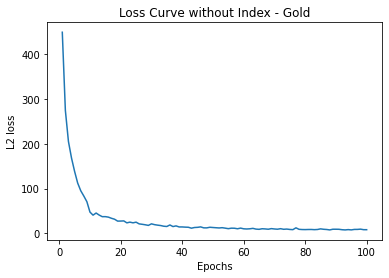

In [93]:
runNeuralNet(X_wo_index_std, y1_std, 'Loss Curve without Index - Gold')


### Silver Prices Dataset


In [94]:
#run linear regression model
lr_woi_wolg_mse_sil = runLinReg(X_wo_index_std, y2_std)

Linear Regression MSE:  0.19697778559009793
0.8199567067063769
[[ 0.3576038  -0.13596828  0.11102984 -0.57718411  1.34850297  0.49611395]]


In [95]:
#run elastic net model
en_woi_wolg_mse_sil = runElasticNet(X_wo_index_std, y2_std)

Elastic Net MSE:  0.19694177683499536
0.8199896197317551
[ 0.35331452 -0.13828429  0.11056245 -0.55681716  1.32761385  0.49256819]
[0.00520167]


In [96]:
#run xgboost model
xg_woi_wolg_mse_sil = runXGBoost(X_wo_index_std, y2_std)

XGBoost MSE:  0.02713080912528367


epoch: 3, loss: 172.2807
epoch: 6, loss: 118.2317
epoch: 9, loss: 96.2663
epoch: 12, loss: 87.0299
epoch: 15, loss: 79.9488
epoch: 18, loss: 75.0850
epoch: 21, loss: 68.7951
epoch: 24, loss: 64.6914
epoch: 27, loss: 59.7623
epoch: 30, loss: 52.0069
epoch: 33, loss: 52.4113
epoch: 36, loss: 49.9096
epoch: 39, loss: 46.4740
epoch: 42, loss: 42.9703
epoch: 45, loss: 41.5327
epoch: 48, loss: 39.5776
epoch: 51, loss: 40.5186
epoch: 54, loss: 34.5755
epoch: 57, loss: 32.4653
epoch: 60, loss: 33.1747
epoch: 63, loss: 28.4836
epoch: 66, loss: 30.1108
epoch: 69, loss: 34.5013
epoch: 72, loss: 30.5191
epoch: 75, loss: 31.3971
epoch: 78, loss: 30.8923
epoch: 81, loss: 31.2705
epoch: 84, loss: 29.0108
epoch: 87, loss: 26.8641
epoch: 90, loss: 28.3162
epoch: 93, loss: 27.8816
epoch: 96, loss: 26.1164
epoch: 99, loss: 24.0452
time:  87.46775650978088
Validation Loss:  0.0994900815976722


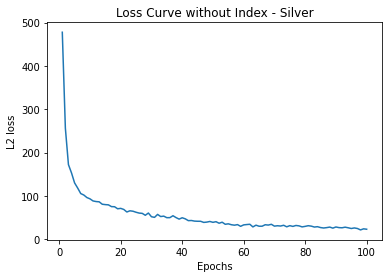

In [97]:
runNeuralNet(X_wo_index_std, y2_std, 'Loss Curve without Index - Silver')

# Without Index
## With Log

### Gold Prices Dataset

In [98]:
#run linear regression model
lr_woi_wlg_mse = runLinReg(X_wo_index_std, y1_log)

Linear Regression MSE:  0.1242067630208908
0.8837777253647738
[[ 0.23383398 -0.03598517  0.08694742  0.63288824  0.33908251  0.52035961]]


In [99]:
#run elastic net model
en_woi_wlg_mse = runElasticNet(X_wo_index_std, y1_log)

Elastic Net MSE:  0.1239968486003295
0.883974145679119
[ 0.23124616 -0.03574125  0.08577091  0.6323181   0.33762689  0.51759501]
[-0.00428389]


In [100]:
#run xgboost model
xg_woi_wlg_mse = runXGBoost(X_wo_index_std, y1_log)

XGBoost MSE:  0.0031323543780586794


epoch: 3, loss: 169.8700
epoch: 6, loss: 69.8429
epoch: 9, loss: 51.8488
epoch: 12, loss: 38.7524
epoch: 15, loss: 30.8939
epoch: 18, loss: 21.9975
epoch: 21, loss: 19.6764
epoch: 24, loss: 17.3825
epoch: 27, loss: 13.3836
epoch: 30, loss: 12.8559
epoch: 33, loss: 12.0353
epoch: 36, loss: 11.5035
epoch: 39, loss: 9.7909
epoch: 42, loss: 10.0208
epoch: 45, loss: 9.7683
epoch: 48, loss: 9.9295
epoch: 51, loss: 8.9002
epoch: 54, loss: 7.9176
epoch: 57, loss: 8.5718
epoch: 60, loss: 8.8607
epoch: 63, loss: 8.4432
epoch: 66, loss: 8.8948
epoch: 69, loss: 7.8903
epoch: 72, loss: 6.5730
epoch: 75, loss: 7.8124
epoch: 78, loss: 7.2158
epoch: 81, loss: 7.0645
epoch: 84, loss: 6.3168
epoch: 87, loss: 6.3770
epoch: 90, loss: 6.4769
epoch: 93, loss: 6.3125
epoch: 96, loss: 6.5000
epoch: 99, loss: 6.7114
time:  83.33166289329529
Validation Loss:  0.00942924931458281


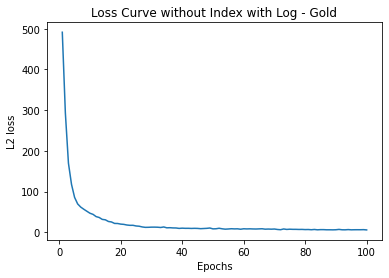

In [101]:
runNeuralNet(X_wo_index_std, y1_log, 'Loss Curve without Index with Log - Gold')

### Silver Prices Dataset

In [102]:
#run linear regression model
lr_woi_wlg_mse_sil = runLinReg(X_wo_index_std, y2_log)

Linear Regression MSE:  0.1769368921635216
0.8322420982451271
[[ 0.36788676 -0.08231817  0.14161027  0.03004844  0.85667216  0.59305206]]


In [103]:
#run elastic net model
en_woi_wlg_mse_sil = runElasticNet(X_wo_index_std, y2_log)

Elastic Net MSE:  0.176739492468885
0.832429257396474
[ 0.36528416 -0.08209581  0.14043912  0.02962559  0.85507964  0.59027836]
[0.0064336]


In [104]:
#run xgboost model
xg_woi_wlg_mse_sil = runXGBoost(X_wo_index_std, y2_log)

XGBoost MSE:  0.014542794549820222


epoch: 3, loss: 119.4203
epoch: 6, loss: 74.0142
epoch: 9, loss: 56.4963
epoch: 12, loss: 49.7407
epoch: 15, loss: 42.9406
epoch: 18, loss: 37.9469
epoch: 21, loss: 34.4435
epoch: 24, loss: 32.1728
epoch: 27, loss: 29.3082
epoch: 30, loss: 28.7677
epoch: 33, loss: 26.6243
epoch: 36, loss: 25.7138
epoch: 39, loss: 22.5829
epoch: 42, loss: 24.6475
epoch: 45, loss: 24.4788
epoch: 48, loss: 22.7130
epoch: 51, loss: 22.0090
epoch: 54, loss: 19.3632
epoch: 57, loss: 21.9984
epoch: 60, loss: 21.6369
epoch: 63, loss: 20.6652
epoch: 66, loss: 19.0946
epoch: 69, loss: 19.4634
epoch: 72, loss: 19.4948
epoch: 75, loss: 18.6698
epoch: 78, loss: 18.8125
epoch: 81, loss: 18.0144
epoch: 84, loss: 17.2659
epoch: 87, loss: 16.5684
epoch: 90, loss: 16.1863
epoch: 93, loss: 14.7198
epoch: 96, loss: 16.9791
epoch: 99, loss: 16.2937
time:  83.23973369598389
Validation Loss:  0.040546293986361295


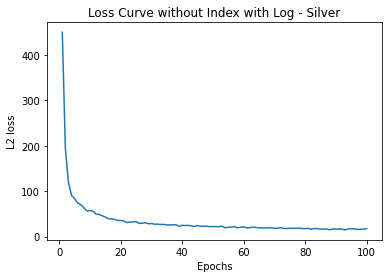

In [105]:
runNeuralNet(X_wo_index_std, y2_log, 'Loss Curve without Index with Log - Silver')

# Transfer Learning

In this part we implemented transfer learning to train on the entire gold dataset and validate on the silver dataset. Since the silver dataset is similar to the gold dataset but not same. We used out fine tuned neural network to do the transfer learning. The network was fine tuned for the gold dataset.

epoch: 3, loss: 62.5781
epoch: 6, loss: 46.8455
epoch: 9, loss: 44.6780
epoch: 12, loss: 49.9700
epoch: 15, loss: 49.9665
epoch: 18, loss: 45.8964
epoch: 21, loss: 43.6752
epoch: 24, loss: 40.7454
epoch: 27, loss: 33.4095
epoch: 30, loss: 31.2256
epoch: 33, loss: 28.0152
epoch: 36, loss: 24.0780
epoch: 39, loss: 20.7108
epoch: 42, loss: 22.4077
epoch: 45, loss: 18.0671
epoch: 48, loss: 19.0697
epoch: 51, loss: 16.6875
epoch: 54, loss: 16.8436
epoch: 57, loss: 16.3466
epoch: 60, loss: 15.0153
epoch: 63, loss: 15.2530
epoch: 66, loss: 13.4330
epoch: 69, loss: 12.1846
epoch: 72, loss: 14.0927
epoch: 75, loss: 12.3129
epoch: 78, loss: 11.3613
epoch: 81, loss: 12.4917
epoch: 84, loss: 9.9508
epoch: 87, loss: 8.8821
epoch: 90, loss: 9.9789
epoch: 93, loss: 9.0292
epoch: 96, loss: 10.3570
epoch: 99, loss: 8.6352
time:  108.60337924957275
Validation Loss:  0.26266863318611766


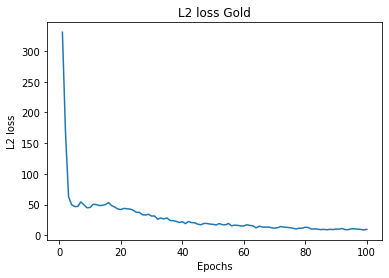

In [106]:
y1_tl = y1_std.copy()
y2_tl = y2_std.copy()

X_tl = X.astype(np.float32)
y1_tl = y1_tl.astype(np.float32)
y2_tl = y2_tl.astype(np.float32)

X_train, X_test, y_train, y_test = np.copy(X_tl), np.copy(X_tl), y1_tl, y2_tl

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

start_time = time.time()
epochs = 100
input_size = 7
hidden_size = 10
model = NeuralNet(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2.5e-4) 
train_mse = []
# training iterations
for epoch in range(epochs):
    running_loss = 0
    for i in range(len(X_train)-1):
        # zero gradient
        optimizer.zero_grad()
        # forward path
        y_predicted = model(X_train[i])
        loss = criterion(y_predicted, y_train[i])
        running_loss += loss.item()
        # backpropagating
        loss.backward()
        # optimizes the weights
        optimizer.step()
    train_mse.append(running_loss)
    if (epoch+1) % 3 == 0:
        print(f'epoch: {epoch+1}, loss: {running_loss:.4f}')

# # Validating model
model.eval()
validation_loss = 0
for i in range(len(X_test)-1):
    outputs = model(X_test[i])
    loss = criterion(outputs, y_test[i])
    # print("loss increment: ", loss.item())
    validation_loss+=loss.item()
print("time: ", time.time()-start_time)
print("Validation Loss: ", validation_loss/(len(X_test)-1))
plt.plot(np.linspace(1, epochs, epochs), train_mse, label='Train')
plt.title('L2 loss Gold')
plt.xlabel('Epochs')
plt.ylabel('L2 loss')
# plt.savefig("nnLossCurveGold.png")
plt.show()

Training on the gold dataset and half of the silver dataset. 

Testing on the remaining half of the silver dataset

epoch: 3, loss: 113.7882
epoch: 6, loss: 121.4238
epoch: 9, loss: 124.8323
epoch: 12, loss: 109.4994
epoch: 15, loss: 109.9027
epoch: 18, loss: 100.3748
epoch: 21, loss: 96.2596
epoch: 24, loss: 85.6708
epoch: 27, loss: 81.0909
epoch: 30, loss: 79.8552
epoch: 33, loss: 69.0630
epoch: 36, loss: 72.6333
epoch: 39, loss: 67.6647
epoch: 42, loss: 64.7121
epoch: 45, loss: 60.5624
epoch: 48, loss: 65.5822
epoch: 51, loss: 60.6839
epoch: 54, loss: 66.4845
epoch: 57, loss: 57.1681
epoch: 60, loss: 59.0723
epoch: 63, loss: 53.0828
epoch: 66, loss: 53.4687
epoch: 69, loss: 53.8593
epoch: 72, loss: 54.8897
epoch: 75, loss: 54.1645
epoch: 78, loss: 48.8926
epoch: 81, loss: 52.8207
epoch: 84, loss: 49.2650
epoch: 87, loss: 52.8543
epoch: 90, loss: 48.1328
epoch: 93, loss: 48.3913
epoch: 96, loss: 51.4097
epoch: 99, loss: 48.3784
time:  159.3712100982666
Validation Loss:  0.5581910695211302


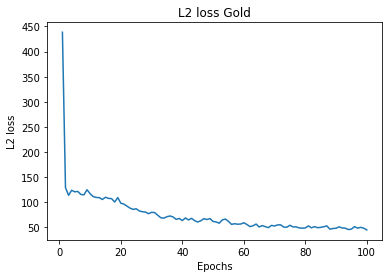

In [107]:
n = int(len(y2_tl)/2)
#print(n)
y_train = np.concatenate((y1_tl, y2_tl[:n]))
y_test = y2_tl[n:]
X_train = np.concatenate((X_tl, X_tl[:n]))
X_test = X_tl[n:]
#for i in range(len(y1_tl)):
 #   print(y1_tl[i], y2_tl[i])

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

start_time = time.time()
epochs = 100
input_size = 7
hidden_size = 10
model = NeuralNet(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2.5e-4) 
train_mse = []
# training iterations
for epoch in range(epochs):
    running_loss = 0
    for i in range(len(X_train)-1):
        # zero gradient
        optimizer.zero_grad()
        # forward path
        y_predicted = model(X_train[i])
        loss = criterion(y_predicted, y_train[i])
        running_loss += loss.item()
        # backpropagating
        loss.backward()
        # optimizes the weights
        optimizer.step()
    train_mse.append(running_loss)
    if (epoch+1) % 3 == 0:
        print(f'epoch: {epoch+1}, loss: {running_loss:.4f}')

# # Validating model
model.eval()
validation_loss = 0
for i in range(len(X_test)-1):
    outputs = model(X_test[i])
    loss = criterion(outputs, y_test[i])
    # print("loss increment: ", loss.item())
    validation_loss+=loss.item()
print("time: ", time.time()-start_time)
print("Validation Loss: ", validation_loss/(len(X_test)-1))
plt.plot(np.linspace(1, epochs, epochs), train_mse, label='Train')
plt.title('L2 loss Gold')
plt.xlabel('Epochs')
plt.ylabel('L2 loss')
# plt.savefig("nnLossCurveGold.png")
plt.show()